# Analyse Bivariée

In [12]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as  sns
sns.set() 

In [13]:
operations_data = pd.read_csv('operations_data_enrichies.csv', parse_dates=[1])

r= 0.2154793323896234
cov= 5165.609236040533


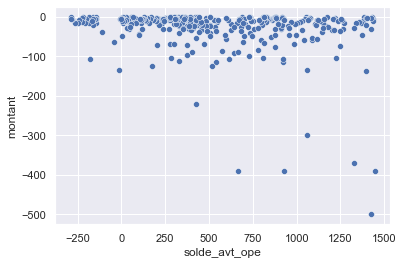

In [14]:
import scipy.stats as st
depenses = operations_data[operations_data['montant']<0]

g = sns.scatterplot(data=depenses, x='solde_avt_ope', y='montant')

print('r=', st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])
print('cov=', np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0])

IndexError: list index out of range

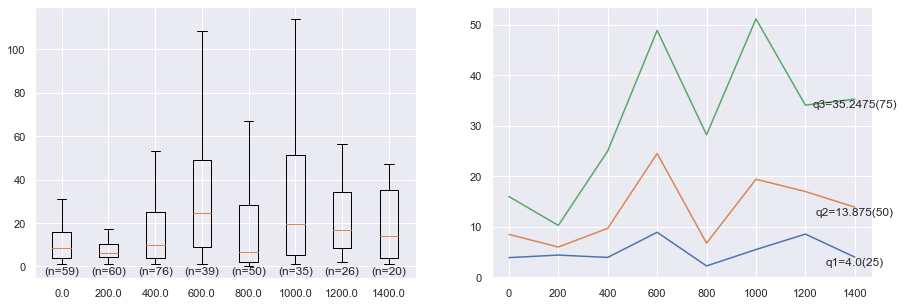

In [17]:
depenses = operations_data[operations_data['montant']<0]
taille_classe = 200 # taille des classes pour la discrétisation
groupes = [] # va recevoir les données agrégées à afficher

# on calcule des tranches allant de 0 au solde maximum par paliers de taille taille_classe
tranches = np.arange(0, max(depenses["solde_avt_ope"]), taille_classe)
tranches += taille_classe/2 # on décale les tranches d'une demi taille de classe
indices = np.digitize(depenses["solde_avt_ope"], tranches) # associe chaque solde à son numéro de classe

quantiles=[25,50,75]

for ind, tr in enumerate(tranches): # pour chaque tranche, ind reçoit le numéro de tranche et tr la tranche en question
    montants = -depenses.loc[indices==ind,"montant"] # sélection des individus de la tranche ind
    if len(montants) > 0:
        g = {
            'valeurs': montants,
            'centre_classe': tr-(taille_classe/2),
            'taille': len(montants),
            'quartiles': [np.percentile(montants,p) for p in quantiles]
        }
        groupes.append(g)

# affichage des boxplots
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)
axes[0].boxplot([g["valeurs"] for g in groupes],
            positions= [g["centre_classe"] for g in groupes], # abscisses des boxplots
            showfliers= False, # on ne prend pas en compte les outliers
            widths= taille_classe*0.4, # largeur graphique des boxplots            
)
# affichage des effectifs de chaque classe
for g in groupes:
    axes[0].text(g["centre_classe"],0,"(n={})".format(g["taille"]),horizontalalignment='center',verticalalignment='top')     


# affichage des quantiles
# quantiles=list(range(70,100,10))
if 100 not in quantiles:
    quantiles.append(100)

for n_quartile in range(len(quantiles)):
    axes[1].plot([g["centre_classe"] for g in groupes],
             [g["quartiles"][n_quartile] for g in groupes])
    axes[1].text(g["centre_classe"],g["quartiles"][n_quartile],"q{}={}({})".format(n_quartile+1,g["quartiles"][n_quartile], quantiles[n_quartile]),horizontalalignment='center',verticalalignment='top')
a= axes[1].set(xlabel='solde_avt_opel', ylabel='montant')

## Attente entre deux Courses

In [ ]:
import datetime as dt

# Selection du sous-échantillon
courses = operations_data[operations_data.categ == "COURSES"]
# On trie les opérations par date
courses = courses.sort_values("date_operation")
# On ramène les montants en positif
courses["montant"] = -courses["montant"]
# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame({"montant":a, "attente":b})
courses = courses[courses['attente']<30]
courses.head()

,montant,attente
date_operation,,
2021-01-18,74.01,7
2021-01-22,12.75,4
2021-01-25,28.01,3
2021-02-01,59.78,7
2021-02-09,51.99,8


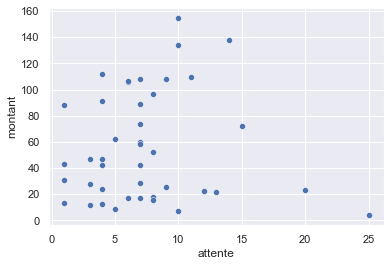

In [ ]:
s = sns.scatterplot(data=courses, x='attente', y='montant')

In [ ]:
import statsmodels.api as sm
Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']
print('a=', a, 'b=', b)

a= 0.22205736118934916 b= 54.78476573024075


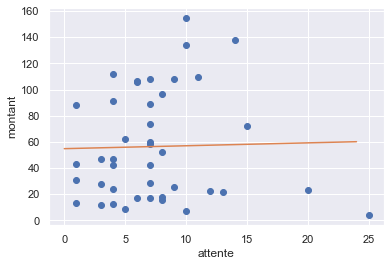

In [ ]:
plt.plot(courses.attente,courses.montant, "o")
attente_max = courses['attente'].max()
plt.plot(np.arange(attente_max),[a*x+b for x in np.arange(attente_max)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

## ANOVA

In [19]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [20]:
def stats2(index_label, df, stat):
    if index_label in df.index:
        df.drop(index_label, inplace=True)
    df= pd.concat([df,pd.DataFrame(data={'min':[stat.min()],'mean':[stat.mean()],'median':[stat.median()],'mode':[stat.mode()[0]],'max':[stat.max()],'var':[stat.var(ddof=0)],'std':[stat.std(ddof=0)],'cv':[np.abs(stat.std(ddof=0)/stat.mean()*100)], 'count':[stat.count()]}, index=[index_label])])

    df2=df['count']*df['std']*df['cv']
    df['dr']=df2/df2.max()*100
    return df

In [21]:
def ANOVA(df, X,Y, all_classes=False):    
    classes = df[X].unique()
    n2=eta_squared(df[X],df[Y])
    print('n²=',n2, Y +' et '+ X , ('sont correlés' if n2>0.5 else 'ne sont pas correlés'))    

    if not all_classes:
        #Retirer les classes à petite dispersion relative (concentrée)
        data = pd.DataFrame()
        for classe in classes:
            data = stats2(classe, data, -df[df[X]==classe][Y])
        for classe in classes:
            if data.loc[classe,'dr'] < 1:
                df = df[df[X]!=classe]   
    
    classes = df[X].unique()
    nb_classes= len(classes)
    
    lines=1 if nb_classes < 4 else 2
    cols=int(round(nb_classes/lines))
    fig, axes = plt.subplots(lines+1, cols, figsize=(18,15), sharex=False, sharey=False)
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    
    for j in range(0, cols):
        for i in range(lines):
            index=j*lines+i 
            data = df[df[X]==classes[index]][Y]
              
            axe=plt.subplot(lines+1,cols,index+1+cols)
            sns.boxplot(y=data, ax=axe, orient='v', showmeans=True, meanprops=meanprops, showfliers = False)
            axe.set_title(classes[index])        
            # sns.swarmplot(y=data, ax=axe, color='.3')
            # axe.set_title(classes[index])

    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    axe=plt.subplot(lines+1,1,1)
    ax= sns.boxplot(y=df[X], x=df[Y], ax=axe, orient='h', showmeans=True, meanprops=meanprops, showfliers = False) #Afficher les moyenne et Cacher les outliers
    # ax= sns.swarmplot(y=df[X], x=df[Y], color='.1', size=2.1)

### Montant Par Catégories

n²= 0.61008520646189 montant et categ sont correlés


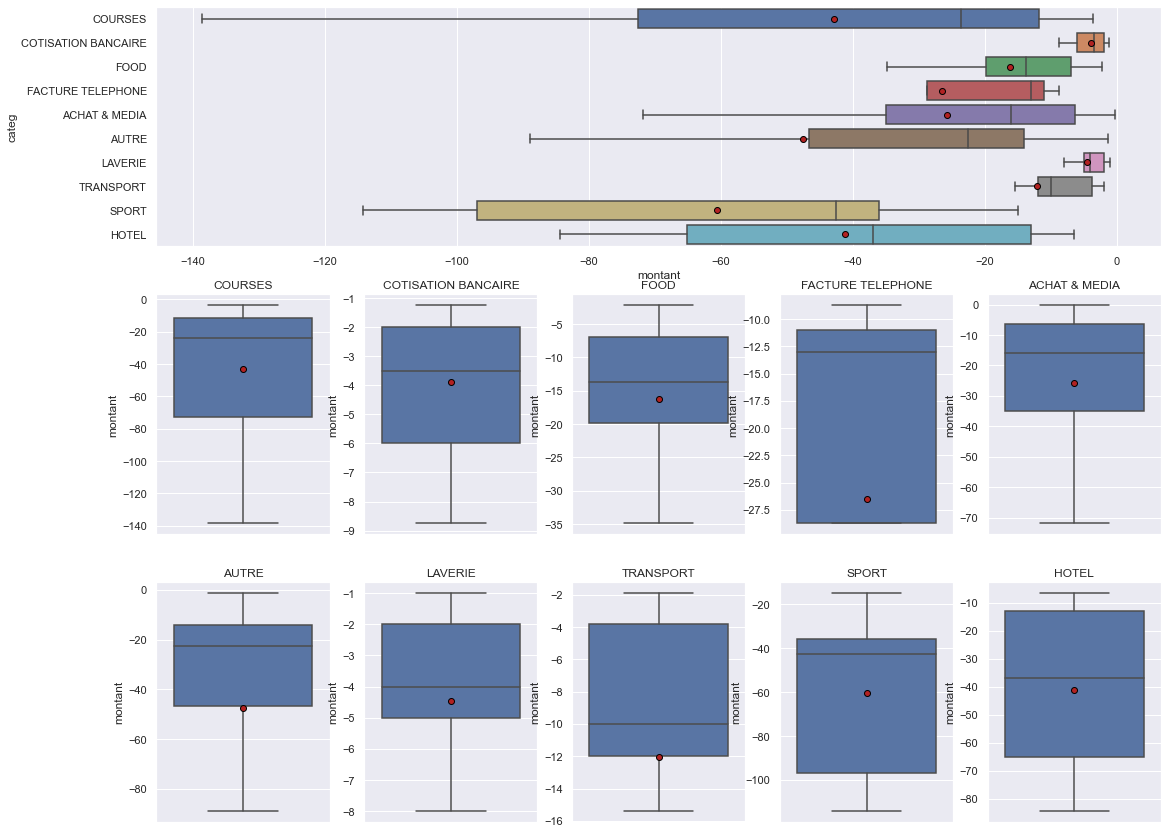

In [34]:
X = "categ" # qualitative
Y = "montant" # quantitative
depenses = operations_data[operations_data['montant']<0]
ANOVA(depenses, X, Y)

### Montant Par Weekend

n²= 0.08591475923068514 montant et weekend ne sont pas correlés


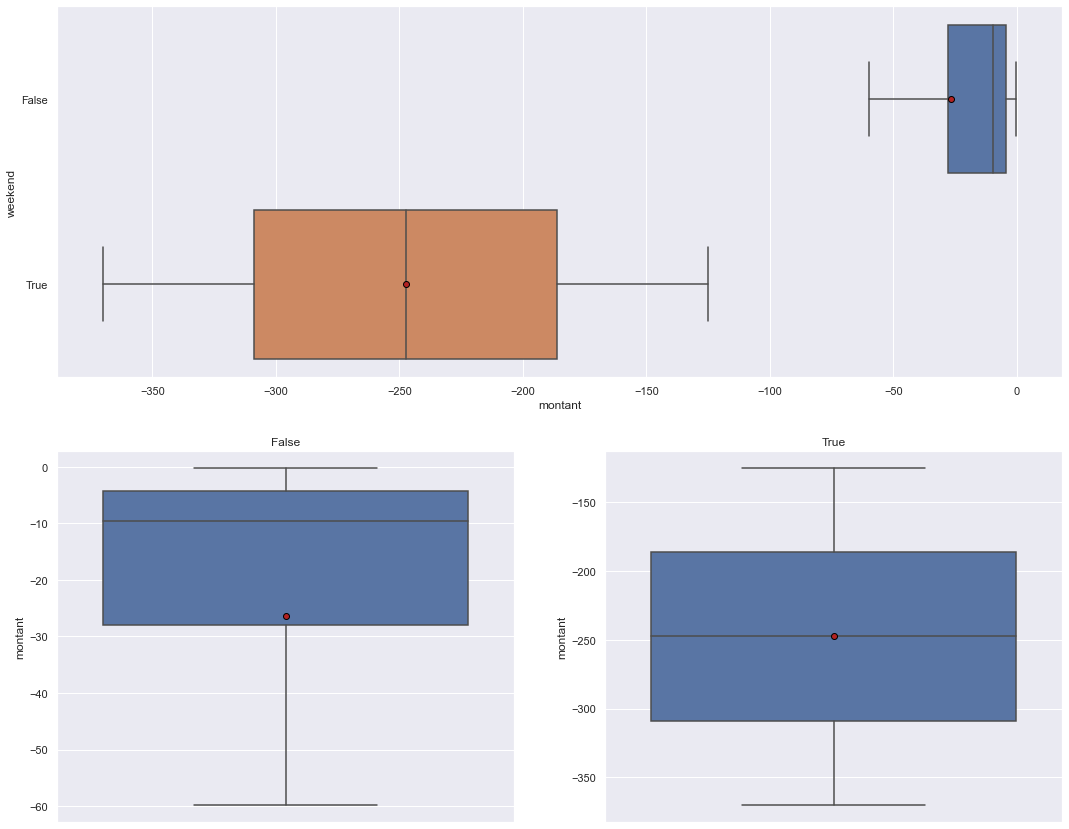

In [23]:
X = "weekend" # qualitative
Y = "montant" # quantitative
depenses = operations_data[operations_data['montant']<0]
ANOVA(depenses, X, Y, True)

### Montant Par Quart-Mois

n²= 0.01823351059699724 montant et quart_mois ne sont pas correlés


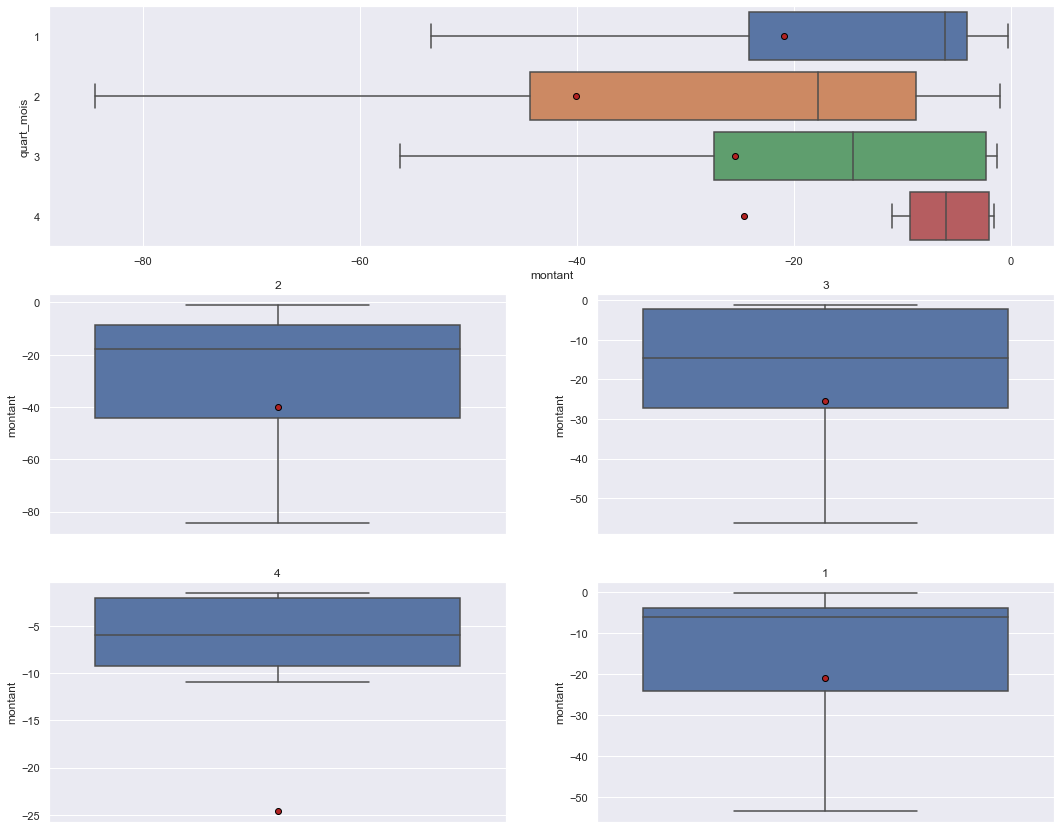

In [24]:
X = "quart_mois" # qualitative
Y = "montant" # quantitative
depenses = operations_data[operations_data['montant']<0]
ANOVA(depenses, X, Y)

### Solde Par Quart-Mois

n²= 0.11322493665278888 solde_avt_ope et quart_mois ne sont pas correlés


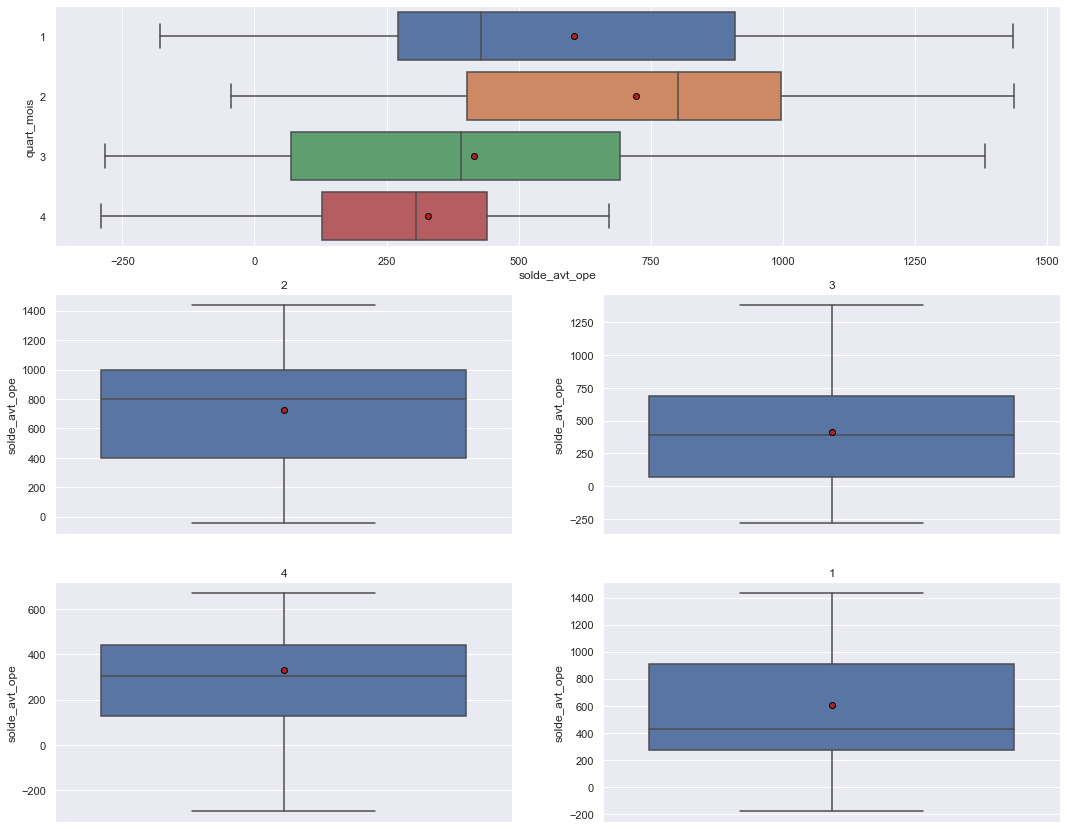

In [25]:
X = "quart_mois" # qualitative
Y = "solde_avt_ope" # quantitative
depenses = operations_data[operations_data['montant']<0]
ANOVA(depenses, X, Y)

### Montant Par Type

n²= 0.1635239388800186 montant et type ne sont pas correlés


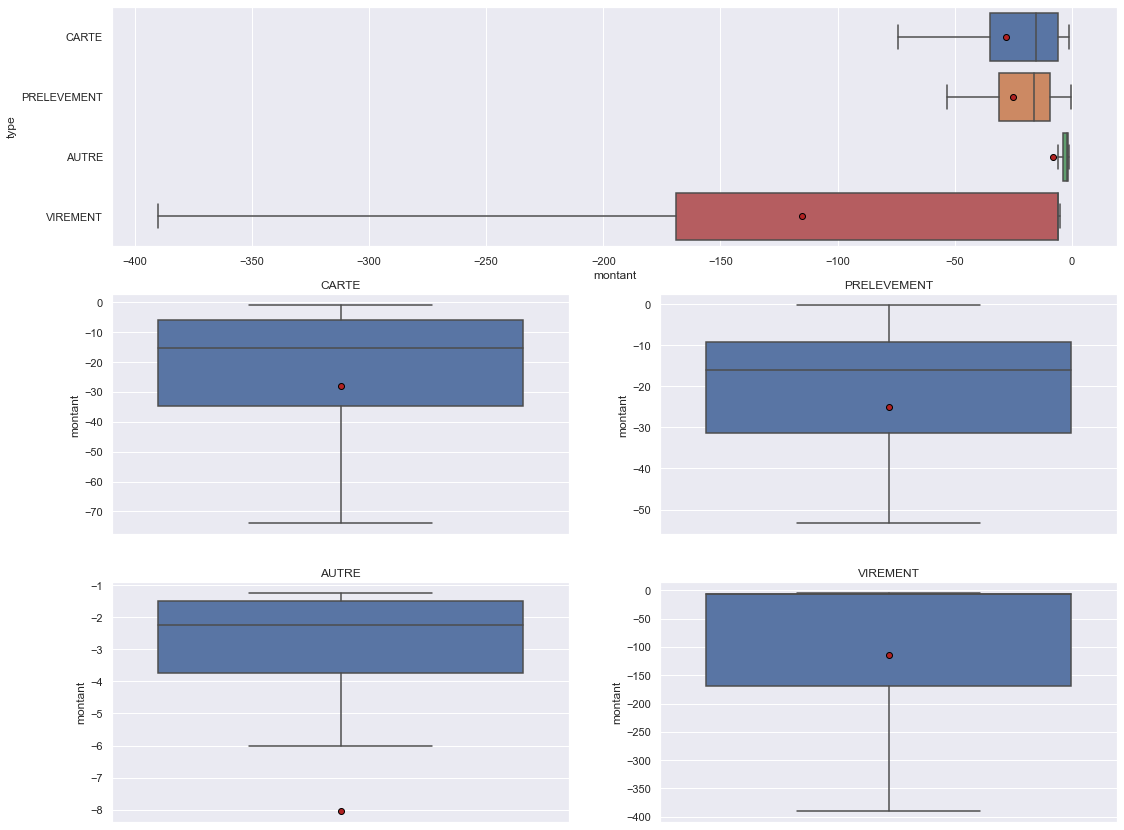

In [26]:
X = "type" # qualitative
Y = "montant" # quantitative
depenses = operations_data[operations_data['montant']<0]
ANOVA(depenses, X, Y)

## CHi-2

In [27]:
import scipy.stats as st

def chi2 (df, X,Y):
    c = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
    cont = c.copy()

    tx = df[X].value_counts()
    ty = df[Y].value_counts()

    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(df)

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(df)
    indep = tx.dot(ty.T) / n

    c = c.fillna(0) # on remplace les valeurs nulles par des 0
    mesure = (c-indep)**2/indep
    xi_n = mesure.sum().sum()
    sns.heatmap(mesure/xi_n,annot=c, cmap=sns.cm.rocket_r)
    print('chi-2=', st.chi2_contingency(c)[0])

### Categ Par Quart-Mois

chi-2= 122.57516899396947


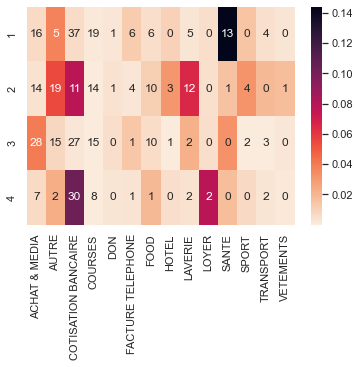

In [28]:
X = "quart_mois" # qualitative
Y = "categ" # qualitative
depenses = operations_data[operations_data['montant']<0]
chi2(depenses, X, Y)

### Tranche-Dépense Par Quart-Mois

chi-2= 11.730764204050715


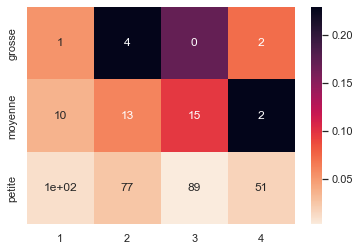

In [29]:
X = "tranche_depense" # qualitative
Y = "quart_mois" # qualitative
depenses = operations_data[operations_data['montant']<0]
chi2(depenses, X, Y)

### Tranche-Dépense Par Categ

chi-2= 323.1529293349367


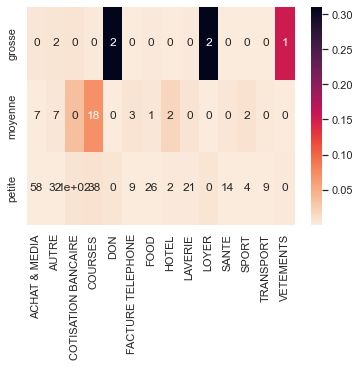

In [30]:
X = "tranche_depense" # qualitative
Y = "categ" # qualitative
depenses = operations_data[operations_data['montant']<0]
chi2(depenses, X, Y)

### Tranche-Dépense Par Type

chi-2= 74.58347539784445


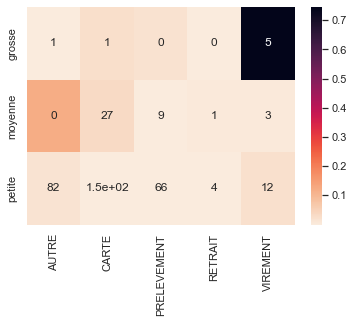

In [31]:
X = "tranche_depense" # qualitative
Y = "type" # qualitative
depenses = operations_data[operations_data['montant']<0]
chi2(depenses, X, Y)

###  Type Par Categ

chi-2= 595.4787322315574


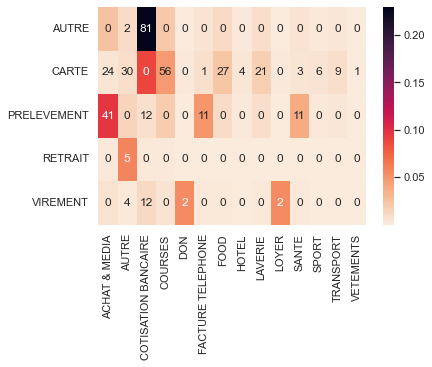

In [32]:
X = "type" # qualitative
Y = "categ" # qualitative
depenses = operations_data[operations_data['montant']<0]
chi2(depenses, X, Y)

###  Sens Par Quart-Mois

chi-2= 10.617842278251358


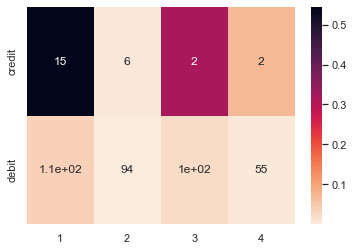

In [33]:
X = "sens" # qualitative
Y = "quart_mois" # qualitative
depenses = operations_data
chi2(depenses, X, Y)